In [139]:
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute._iterative import IterativeImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as parser
from sklearn.impute import SimpleImputer as Imputer, SimpleImputer
from sklearn.neighbors import NearestNeighbors as neigh
from sklearn.neighbors import KNeighborsRegressor as neigh
from sklearn.model_selection import train_test_split as split
from sklearn import metrics
from math import sqrt
import json
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from missingpy import KNNImputer, MissForest
import copy

In [140]:
merged_data = pd.read_csv('trained_datas.csv',index_col=0)

## Jednoduchy strom
Vybrali sme si atribut mean_clucose, podla ktoreho budeme zostrojovat rozhodovanie.
Pricom hlavne vybranie intervalov je zalozene na histograme.

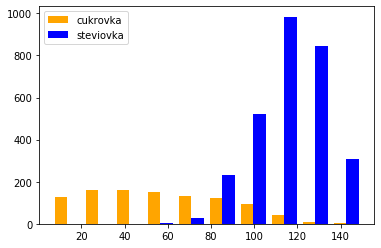

In [141]:
positive = merged_data[merged_data['class']  == 1]
negative = merged_data[merged_data['class']  == 0]

x = [positive['mean_glucose'], negative['mean_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])

V tomto grafe mozeme vidiet, ze hodnoty mean glucose nad 120 zodpovedaju pacientom, 
ktori nemaju cukrovku. A zasa hodnoty pod 80 zodpovedaju pacientom, ktori maju cukrovku. 
Preto prvy uzol pri rozhodovani bude taky, ktory bude rozdelovat data pod 80, nad 120.

count    789.000000
mean       0.940431
std        0.236837
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

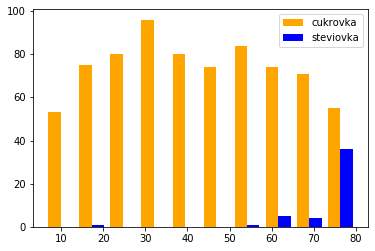

In [142]:
uzol1 = merged_data[merged_data['mean_glucose'] < 80]

positive = uzol1[uzol1['class']  == 1]
negative = uzol1[uzol1['class']  == 0]

x = [positive['mean_glucose'], negative['mean_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
uzol1['class'].describe()

Pri hodnotach mean_glucose mensich ako 80, sme zistili, ze viac ako 94% pacientov maju cukrovku.
S touto percotualnou hodnotout sme spokojny, preto tento uzol dalej uz nerozsirujeme.

count    3144.000000
mean        0.083333
std         0.276429
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: class, dtype: float64

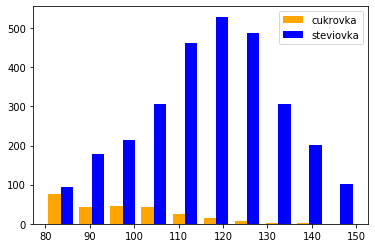

In [143]:
uzol2 = merged_data[merged_data['mean_glucose'] > 80]

positive = uzol2[uzol2['class']  == 1]
negative = uzol2[uzol2['class']  == 0]

x = [positive['mean_glucose'], negative['mean_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
uzol2['class'].describe()

Pri hodnotach nad 120 mozeme spozorovat, ze sa jedna o pacientov bez cukrovky.
Vdaka tomu ziskavame novy interval, podla ktoreho budeme znova rozdelovat.

count    1256.000000
mean        0.011146
std         0.105029
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: class, dtype: float64

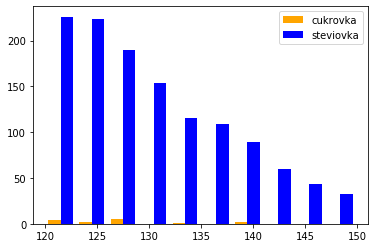

In [144]:
uzol3 = merged_data[merged_data['mean_glucose'] > 120]

positive = uzol3[uzol3['class']  == 1]
negative = uzol3[uzol3['class']  == 0]

x = [positive['mean_glucose'], negative['mean_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
uzol3['class'].describe()

Mozeme vidiet, ze percentualna presnost pre hodnoty vyssie ako 120 je takmer 99%. Co je dost dobre.

count    1887.000000
mean        0.131426
std         0.337955
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: class, dtype: float64

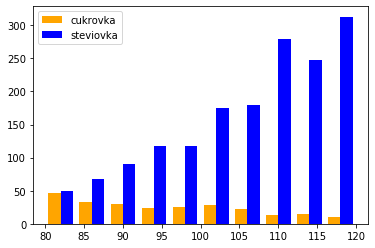

In [145]:
uzol4 = merged_data[(merged_data['mean_glucose'] < 120) & (merged_data['mean_glucose'] > 80)]

positive = uzol4[uzol4['class']  == 1]
negative = uzol4[uzol4['class']  == 0]

x = [positive['mean_glucose'], negative['mean_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
uzol4['class'].describe()

Hodnoty nad 105 vyzeraju byt dost v prospech pacientov, ktori chorobu nemaju.
Preto sa na tento interval ideme zamerat.

count    1043.000000
mean        0.051774
std         0.221676
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: class, dtype: float64

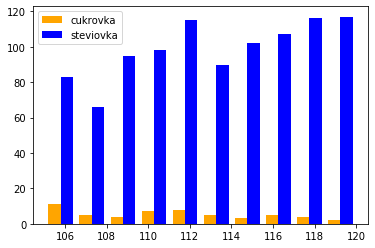

In [146]:
uzol5 = merged_data[(merged_data['mean_glucose'] < 120) & (merged_data['mean_glucose'] > 105)]

positive = uzol5[uzol5['class']  == 1]
negative = uzol5[uzol5['class']  == 0]

x = [positive['mean_glucose'], negative['mean_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
uzol5['class'].describe()



Mozeme vidiet, ze hodnoty dosiahli 94% podiel pacientov bez choroby a s pacienti s chorobou.
A dalej sa budeme zaoberat intervalu mensiemu ako 105 a vacsiemu ako 80.

count    843.000000
mean       0.230130
std        0.421166
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: class, dtype: float64

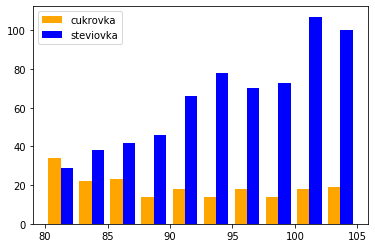

In [147]:
uzol6 = merged_data[(merged_data['mean_glucose'] < 105) & (merged_data['mean_glucose'] > 80)]

positive = uzol6[uzol6['class']  == 1]
negative = uzol6[uzol6['class']  == 0]

x = [positive['mean_glucose'], negative['mean_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
uzol6['class'].describe()

Blizsie sa pozrieme na interval od 90 po 105, nakolko pozorujeme vyraznu prevahu pacientov bez choroby
diabetes milisus

count    591.000000
mean       0.170897
std        0.376738
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: class, dtype: float64

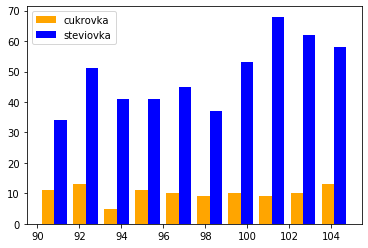

In [148]:
uzol7 = merged_data[(merged_data['mean_glucose'] < 105) & (merged_data['mean_glucose'] > 90)]

positive = uzol7[uzol7['class']  == 1]
negative = uzol7[uzol7['class']  == 0]

x = [positive['mean_glucose'], negative['mean_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
uzol7['class'].describe()

Vidime, ze pri tomto intervale uz ku vyraznejsiemu prekrivu pacientov s chorobou 
a bez choroby ako pri predoslych intervaloch, avsak pacientov bez choroby je takmer 83% a tuto hodnotu
povazujeme za dostacujucu pre oznacenie tohto intervalu v prospech pacientov bez choroby.

A ostava nam uz iba interval vacsie a rovne 80 a mensie a rovne 90. 

count    252.000000
mean       0.369048
std        0.483507
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

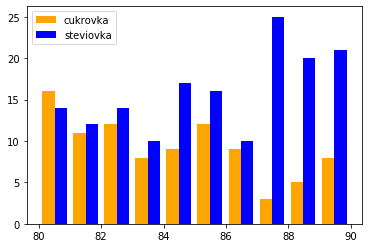

In [149]:
uzol8 = merged_data[(merged_data['mean_glucose'] <= 90) & (merged_data['mean_glucose'] >= 80)]

positive = uzol8[uzol8['class']  == 1]
negative = uzol8[uzol8['class']  == 0]

x = [positive['mean_glucose'], negative['mean_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
uzol8['class'].describe()

Pre interval vacsie a rovne 80 a mensie a rovne 90, neviem uz presnejsie urcit podla jedneho atributu, 
pretoze je tu 63% pacientov bez cukrovky, preto tento interval by sme bud zaklasifikoval ako pacienti 
s cukrovkou alebo pacienti pri ktorych dalej, nedokazeme rozhodnut. 

In [ ]:
# Strom na urcenie ci pacient ma chorobu vyzera nasledovne
merged_data[(merged_data['mean_glucose'] <= 80)]

# Strom na urcenie ci pacient nema chorobu vyzera nasledovne
merged_data[(merged_data['mean_glucose'] >= 9)]

## Komplikovany strom

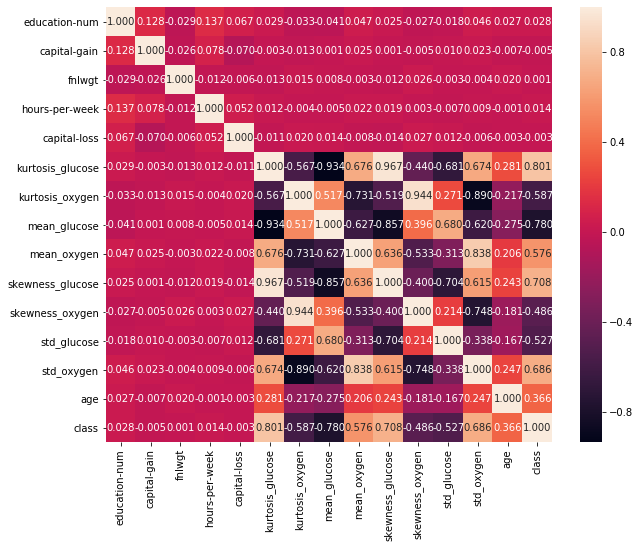

In [150]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(merged_data.corr(), ax=ax, annot=True, fmt=".3f")

Pomocou heatmapy sme vybrali stlpce, ktore maju najvacsiu korelaciu s stlpcom class
Vybrali sme kurtosis_glucose, st_oxygen, age

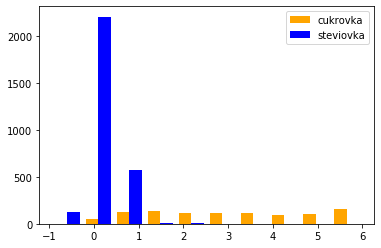

In [151]:
positive = merged_data[merged_data['class']  == 1]
negative = merged_data[merged_data['class']  == 0]

x = [positive['kurtosis_glucose'], negative['kurtosis_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])

Vdaka histograme vyberenie interval s hodnotami mensie a rovne ako 1.

count    1738.000000
mean        0.008631
std         0.092526
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: class, dtype: float64

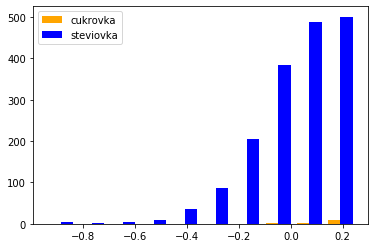

In [152]:
ct1 = merged_data[(merged_data['kurtosis_glucose'] <= 0.25)]

positive = ct1[ct1['class']  == 1]
negative = ct1[ct1['class']  == 0]

x = [positive['kurtosis_glucose'], negative['kurtosis_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
ct1['class'].describe()

Ostrielani predoslou analyzou sme dokazali vybrat intervali len tak od oka. Vidime, ze pokial rozdelime data podla
kurtosis glucose a hranicou mensie a rovne ako 0.25, vieme ziskat 99.2% podiel pacientov bez a pacientov s chorobu

count    497.000000
mean       0.997988
std        0.044856
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

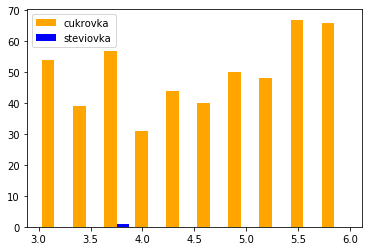

In [153]:
ct2 = merged_data[(merged_data['kurtosis_glucose'] >= 3)]

positive = ct2[ct2['class']  == 1]
negative = ct2[ct2['class']  == 0]

x = [positive['kurtosis_glucose'], negative['kurtosis_glucose']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
ct2['class'].describe()

Taktiez pokial data rozdelime podla kurtosis glucose a interval vacsi a rovny 3, vieme ziskat 99,79%
podiel pacientov s a bez choroby.
dalej si ulozime data ulozime a budeme pokracovat s inym atributom.

count    1698.000000
mean        0.290342
std         0.454054
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: class, dtype: float64

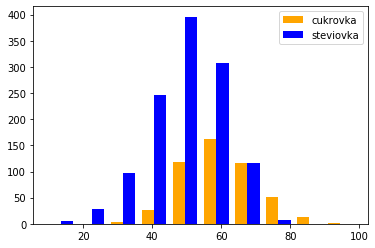

In [154]:
ct3 = merged_data[(merged_data['kurtosis_glucose'] <= 3) & (merged_data['kurtosis_glucose'] >= 0.25)]

positive = ct3[ct3['class']  == 1]
negative = ct3[ct3['class']  == 0]

x = [positive['age'], negative['age']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
ct3['class'].describe()

Po vizualizacia dat pomocou ineho stlpca ako kurtosis_glucose vieme znova najst hodnoty, ktore by nam
mohli ukazat charakteristika pre rozlisenie pacientov s chorobou a bez choroby. Pouzijeme stlpec age,
pricom zoberieme interval do 35, a pre pacientov s chorobou zoberieme interval nad 80.

count    136.000000
mean       0.029412
std        0.169582
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: class, dtype: float64

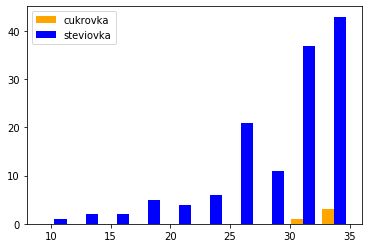

In [155]:
ct3 = merged_data[(merged_data['kurtosis_glucose'] <= 3) & (merged_data['kurtosis_glucose'] >= 0.25)]
ct4 = ct3[(ct3['age'] <= 35)]

positive = ct4[ct4['class']  == 1]
negative = ct4[ct4['class']  == 0]

x = [positive['age'], negative['age']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
ct4['class'].describe()

Identifikovali sme dalsi interval no teraz pre stlpec age, tento interval je pokial hodnota
je mensia a rovna ako 35. Vdaka tomuto intervalu vieme ziskat 97,1% podiel pacientov bez chorobou a s chorobou

count    22.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: class, dtype: float64

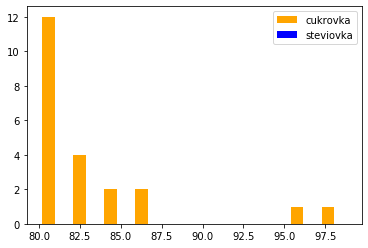

In [156]:
ct5 = ct3[(ct3['age'] >= 80)]

positive = ct5[ct5['class']  == 1]
negative = ct5[ct5['class']  == 0]

x = [positive['age'], negative['age']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
ct5['class'].describe()

V intervale vacsie alebo rovne 80 sme zistili, ze je 100% podiel pacientov s chorobou a bez choroby.
Preto tento interval budeme zahrnat do stromu.

count    1540.000000
mean        0.303247
std         0.459810
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: class, dtype: float64

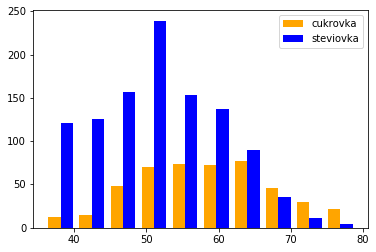

In [157]:
ct6 = ct3[(ct3['age'] < 80) & (ct3['age'] > 35)]

positive = ct6[ct6['class']  == 1]
negative = ct6[ct6['class']  == 0]

x = [positive['age'], negative['age']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
ct6['class'].describe()

Roznorodost v intervale mensie ako 80 a zaroven vacsie ako 35 je prilis velka, preto uz nevieme pouzit
tento stlpec pre rozhodovanie a pouzijeme iny. Pouzijeme stlpec std_oxygen.

count    1540.000000
mean        0.303247
std         0.459810
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: class, dtype: float64

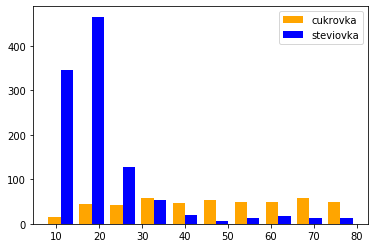

In [158]:
positive = ct6[ct6['class']  == 1]
negative = ct6[ct6['class']  == 0]

x = [positive['std_oxygen'], negative['std_oxygen']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
ct6['class'].describe()

Pomocou grafe vieme identifikovat dalsi interval a to mensie ako 20, ktory by sa dal este pouzit pri
rozhodovani o akeho pacienta ide.

count    965.000000
mean       0.080829
std        0.272714
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: class, dtype: float64

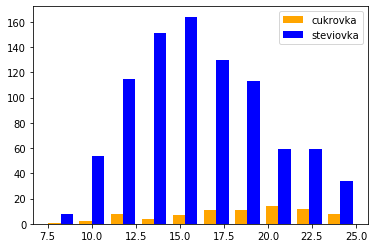

In [163]:
ct7 = ct6[(ct6['std_oxygen'] <= 25)]

positive = ct7[ct7['class']  == 1]
negative = ct7[ct7['class']  == 0]

x = [positive['std_oxygen'], negative['std_oxygen']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
ct7['class'].describe()

Vidime, ze tento interval nam dava celkom dobru hodnotu a to 92% podiel pacienta bez choroby a pacienta s 
chorobou. Preto tento interval tiez zahrnieme do nasho stromu.

count    575.000000
mean       0.676522
std        0.468211
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

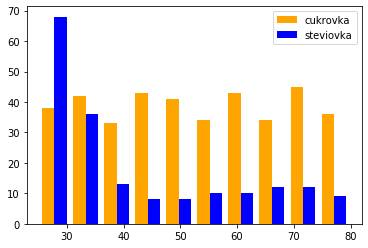

In [164]:
ct7 = ct6[(ct6['std_oxygen'] > 25)]

positive = ct7[ct7['class']  == 1]
negative = ct7[ct7['class']  == 0]

x = [positive['std_oxygen'], negative['std_oxygen']]
plt.hist(x, color=['orange', 'blue'])
plt.legend(['cukrovka', 'steviovka'])
ct7['class'].describe()

Dalsie hodnoty su uz nejasne nevieme na viac ako 70% identifikovat intervaly ktore by davali lepsie vysledky
preto nas rozhodovaci strom uz nebudeme dalej rozsirovat a tieto data by sme specifikovali ako
nevieme urcite.

In [ ]:
# Strom pre urcenie ci pacient nema chorobu je nasledovny
merged_data[(merged_data['std_oxygen'] <= 25)]
merged_data[(merged_data['age'] <= 35 )]
merged_data[(merged_data['kurtosis_glucose'] <= 0.25)]

In [ ]:
# Strom pre urcenie ci pacient ma chorobu je nasledovny
merged_data[(merged_data['age'] >= 80 )]
merged_data[(merged_data['kurtosis_glucose'] >= 3)]

Pre ostatne intervaly vieme urcit len s velmi malou pravdepodobnostou ci pacient ma alebo 
nema chorobu